## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5rawcomp' #dataset-compression
TRANSFORM = 'erb-male' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
male_erb_1e5rawcomp_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os
import sys

sys.path.append('/scratch/users/lievhenry/hierarchical-bayesian-model-validation/utilities')

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

print(os.getcwd())
print(ROOT_DIR)
print(CWD)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

/Users/jiaxin/Documents/Summer 2025/hierarchical-bayesian-model-validation/results-audio/case-studies/ravdess/1e5rawcomp/erb/male
/Users/jiaxin/Documents/Summer 2025/hierarchical-bayesian-model-validation
/Users/jiaxin/Documents/Summer 2025/hierarchical-bayesian-model-validation/results-audio/case-studies/ravdess/1e5rawcomp/erb/male


'/Users/jiaxin/Documents/Summer 2025/hierarchical-bayesian-model-validation/results-audio/case-studies/ravdess/1e5rawcomp/erb/male'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


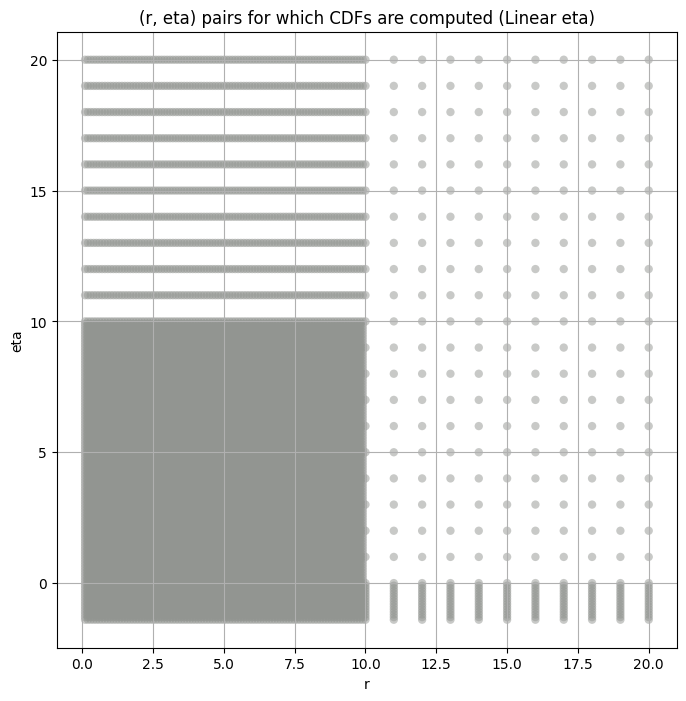

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
band,,,,,,,
2,0.028308,0.022991,0.034663,61.312623,37.835383,93.143808,196196.0
3,0.465179,0.410659,0.523962,20.291024,17.139798,23.690720,218424.0
5,2.054688,1.901839,2.212182,6.662686,5.765408,7.674442,2163728.0
6,1.441145,1.327830,1.557888,7.673075,6.762664,8.657274,1092936.0
8,0.119060,0.104959,0.135463,22.719707,14.181014,38.698902,7083852.0
9,0.038690,0.034166,0.044393,23.432596,12.307179,61.115653,10628850.0
11,0.017679,0.014550,0.021377,52.743853,33.994200,94.052447,13469170.0
12,0.005020,0.003981,0.006599,93.877350,41.096655,280.321252,44356618.0
14,0.000373,0.000267,0.000750,620.008513,46.077857,1725.190022,24973922.0


## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
band,,,,,,,,,,,,
2,0.028308,0.028308,0.024920,0.022798,0.021247,0.020066,0.018311,0.016988,0.015947,0.015113,0.014432,0.012887
3,0.465179,0.465179,0.445240,0.429554,0.415758,0.403333,0.381484,0.362629,0.346101,0.331269,0.317780,0.283425
5,2.054688,2.054688,2.012056,1.978205,1.947870,1.919858,1.869070,1.823450,1.781636,1.742953,1.706930,1.610804
6,1.441145,1.441145,1.411239,1.386490,1.364283,1.343914,1.307094,1.273858,1.243265,1.214763,1.188037,1.115849
8,0.119060,0.119060,0.111170,0.106684,0.103159,0.100191,0.095276,0.091262,0.087842,0.084853,0.082186,0.075553
9,0.038690,0.038690,0.036082,0.034746,0.033712,0.032847,0.031422,0.030249,0.029235,0.028337,0.027527,0.025468
11,0.017679,0.017679,0.015875,0.014838,0.014028,0.013349,0.012237,0.011338,0.010582,0.009932,0.009360,0.007988
12,0.005020,0.005020,0.004329,0.003998,0.003746,0.003539,0.003207,0.002946,0.002730,0.002547,0.002388,0.002013
14,0.000373,0.000373,0.000290,0.000266,0.000248,0.000233,0.000209,0.000191,0.000176,0.000164,0.000153,0.000128


In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
band,,,,,,,,,,,,,,
2,0.028308,0.022991,0.034663,61.312623,37.835383,93.143808,196196.0,0.003010,0.3,-0.6,1.587532e-04,200.0,0.016988,0.003065
3,0.465179,0.410659,0.523962,20.291024,17.139798,23.690720,218424.0,0.014987,0.2,-1.0,3.304634e-04,0.0,0.465179,0.002905
5,2.054688,1.901839,2.212182,6.662686,5.765408,7.674442,2163728.0,0.007505,0.7,-1.1,3.035913e+00,75.0,1.947870,0.000923
6,1.441145,1.327830,1.557888,7.673075,6.762664,8.657274,1092936.0,0.009244,0.7,-1.2,2.931586e+00,100.0,1.343914,0.001299
8,0.119060,0.104959,0.135463,22.719707,14.181014,38.698902,7083852.0,0.003284,0.5,-1.1,8.268025e-02,0.0,0.119060,0.000510
9,0.038690,0.034166,0.044393,23.432596,12.307179,61.115653,10628850.0,0.002819,0.5,-1.1,2.505723e-02,25.0,0.036082,0.000417
11,0.017679,0.014550,0.021377,52.743853,33.994200,94.052447,13469170.0,0.006865,0.1,-0.4,2.367803e-14,25.0,0.015875,0.000370
12,0.005020,0.003981,0.006599,93.877350,41.096655,280.321252,44356618.0,0.004552,0.1,-0.4,6.456972e-15,25.0,0.004329,0.000204
14,0.000373,0.000267,0.000750,620.008513,46.077857,1725.190022,24973922.0,0.007636,0.1,-0.1,4.244123e-17,250.0,0.000176,0.000272


## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
band,,,,,,,,,,,,,,,,,,,,
2,0.028308,0.022991,0.034663,61.312623,37.835383,93.143808,196196.0,0.003010,0.3,-0.6,1.587532e-04,200.0,0.017603,0.003065,0.002703,0.30,-0.62,1.740868e-04,175.0,248310
3,0.465179,0.410659,0.523962,20.291024,17.139798,23.690720,218424.0,0.014987,0.2,-1.0,3.304634e-04,0.0,0.429554,0.002905,0.013645,0.25,-1.10,6.235392e-03,50.0,10237
5,2.054688,1.901839,2.212182,6.662686,5.765408,7.674442,2163728.0,0.007505,0.7,-1.1,3.035913e+00,75.0,2.054688,0.000923,0.004584,0.80,-1.15,4.590333e+00,0.0,85576
6,1.441145,1.327830,1.557888,7.673075,6.762664,8.657274,1092936.0,0.009244,0.7,-1.2,2.931586e+00,100.0,1.411239,0.001299,0.008527,0.66,-1.20,2.784247e+00,25.0,25615
8,0.119060,0.104959,0.135463,22.719707,14.181014,38.698902,7083852.0,0.003284,0.5,-1.1,8.268025e-02,0.0,0.111170,0.000510,0.002070,0.50,-1.09,7.449108e-02,25.0,442740
9,0.038690,0.034166,0.044393,23.432596,12.307179,61.115653,10628850.0,0.002819,0.5,-1.1,2.505723e-02,25.0,0.038690,0.000417,0.001885,0.49,-1.10,2.519787e-02,0.0,498226
11,0.017679,0.014550,0.021377,52.743853,33.994200,94.052447,13469170.0,0.006865,0.1,-0.4,2.367803e-14,25.0,0.017679,0.000370,0.004916,0.10,-0.42,3.017086e-14,0.0,78919
12,0.005020,0.003981,0.006599,93.877350,41.096655,280.321252,44356618.0,0.004552,0.1,-0.4,6.456972e-15,25.0,0.004329,0.000204,0.004552,0.10,-0.40,6.456972e-15,25.0,86634
14,0.000373,0.000267,0.000750,620.008513,46.077857,1725.190022,24973922.0,0.007636,0.1,-0.1,4.244123e-17,250.0,0.000209,0.000272,0.006300,0.08,0.20,3.004172e-22,150.0,48777


## Comparing Empirical and Computed CDF/PDF

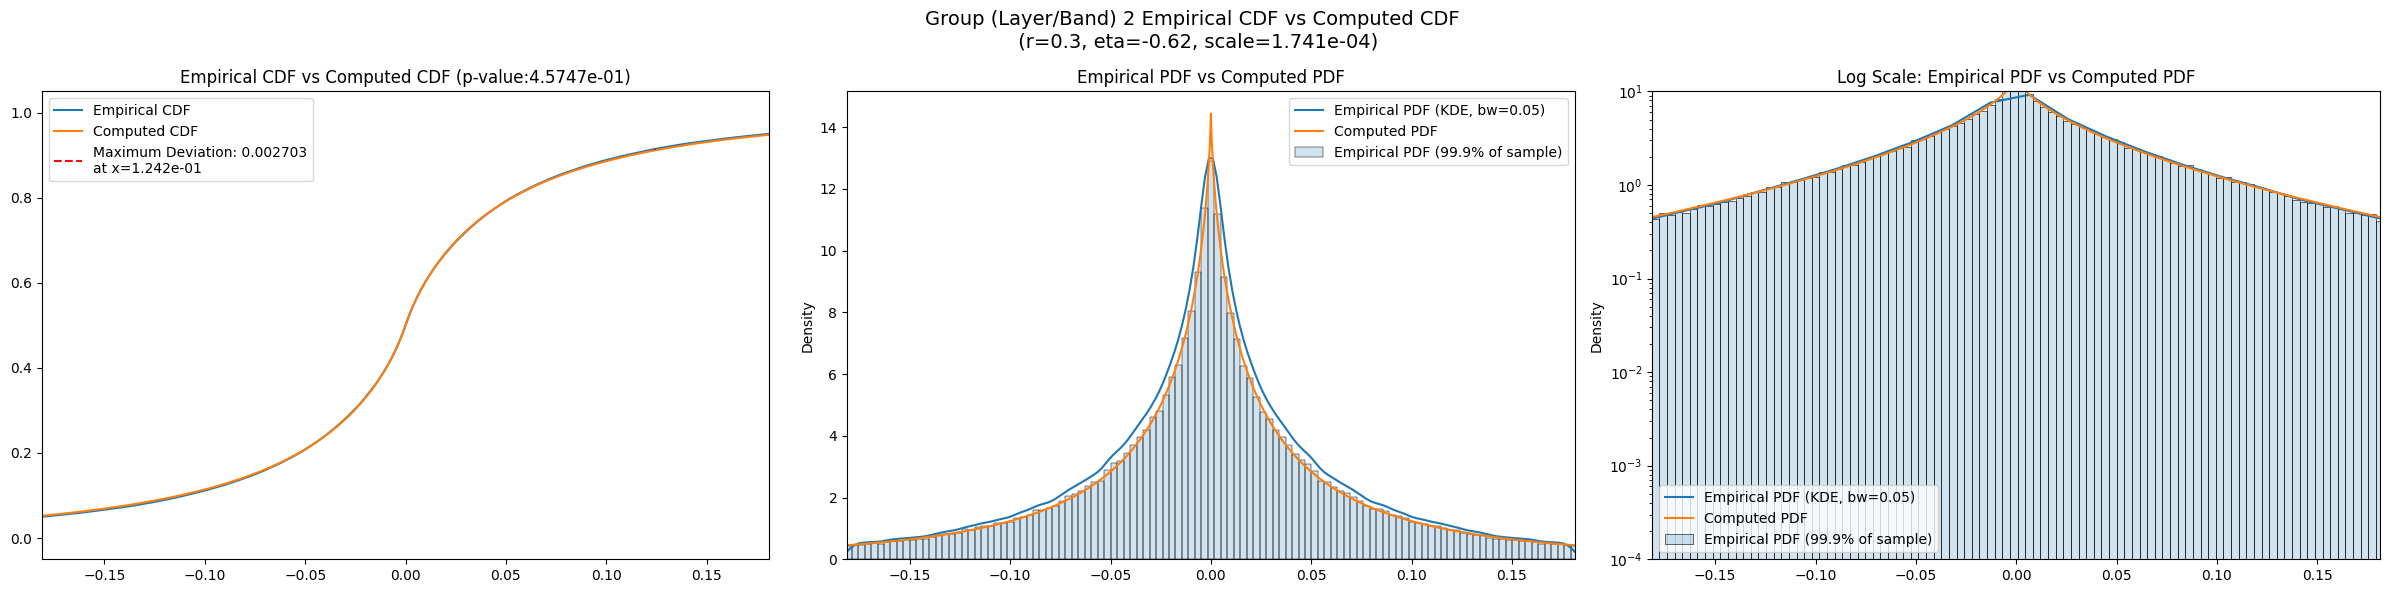

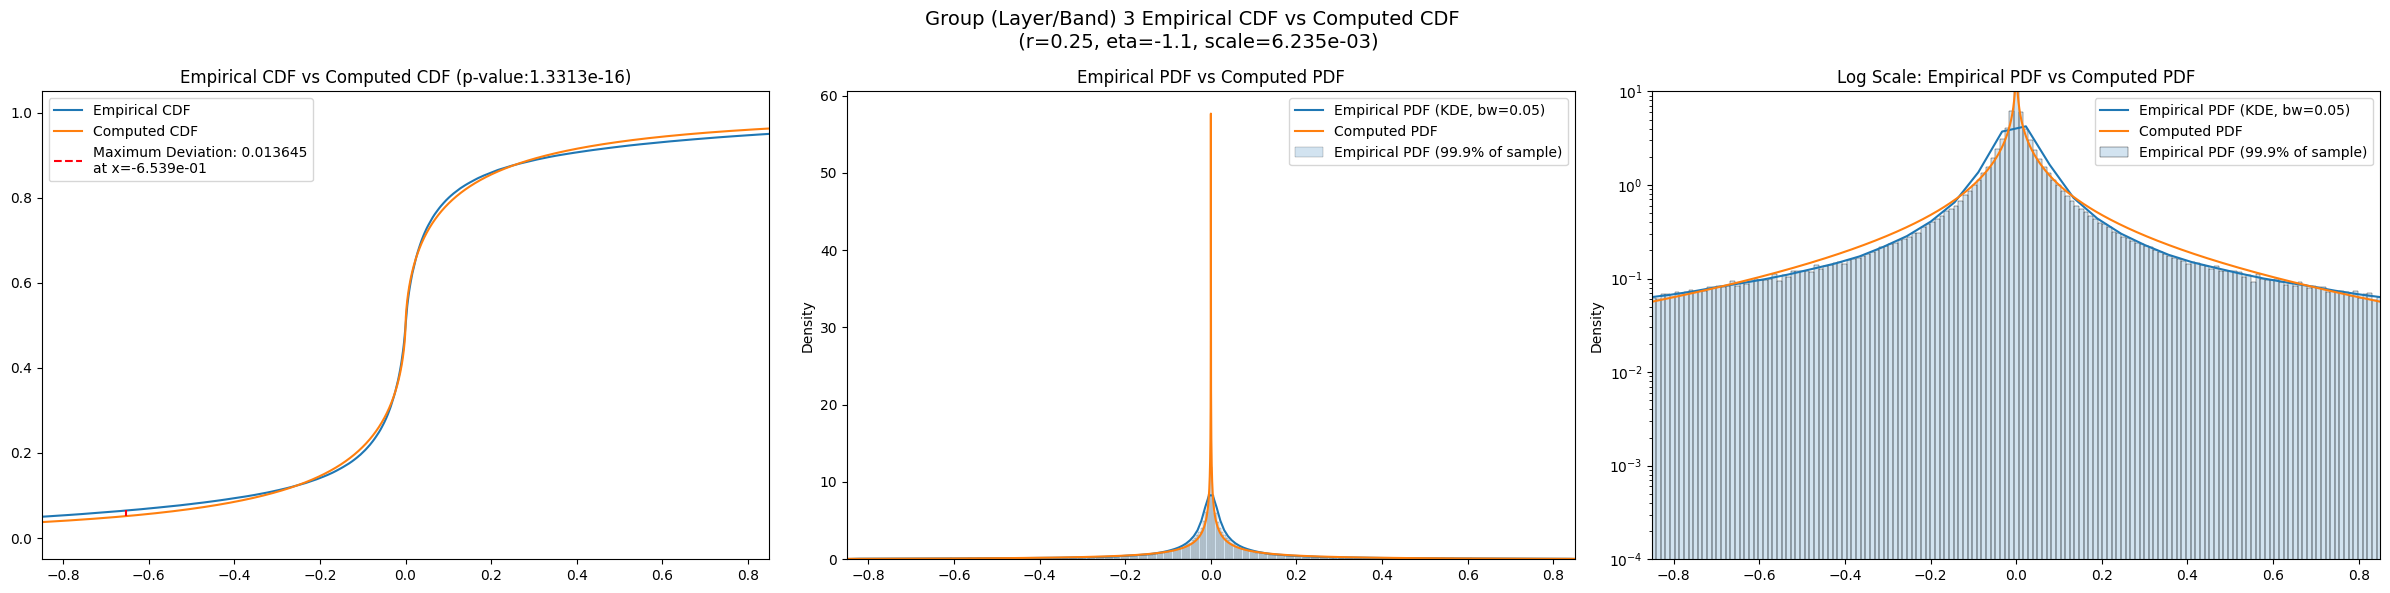

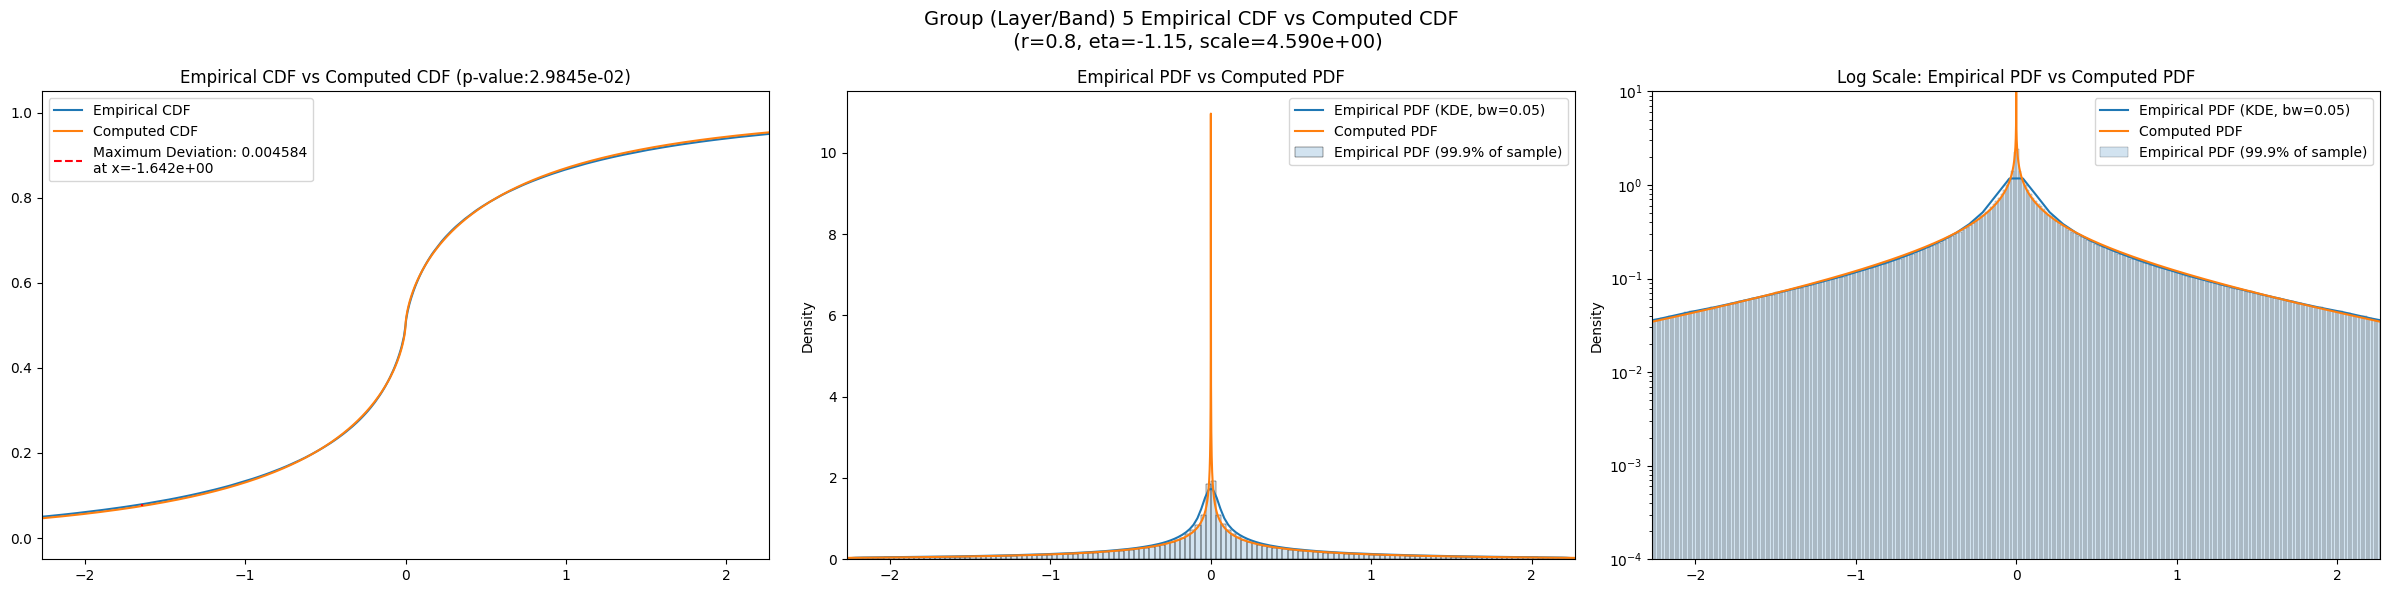

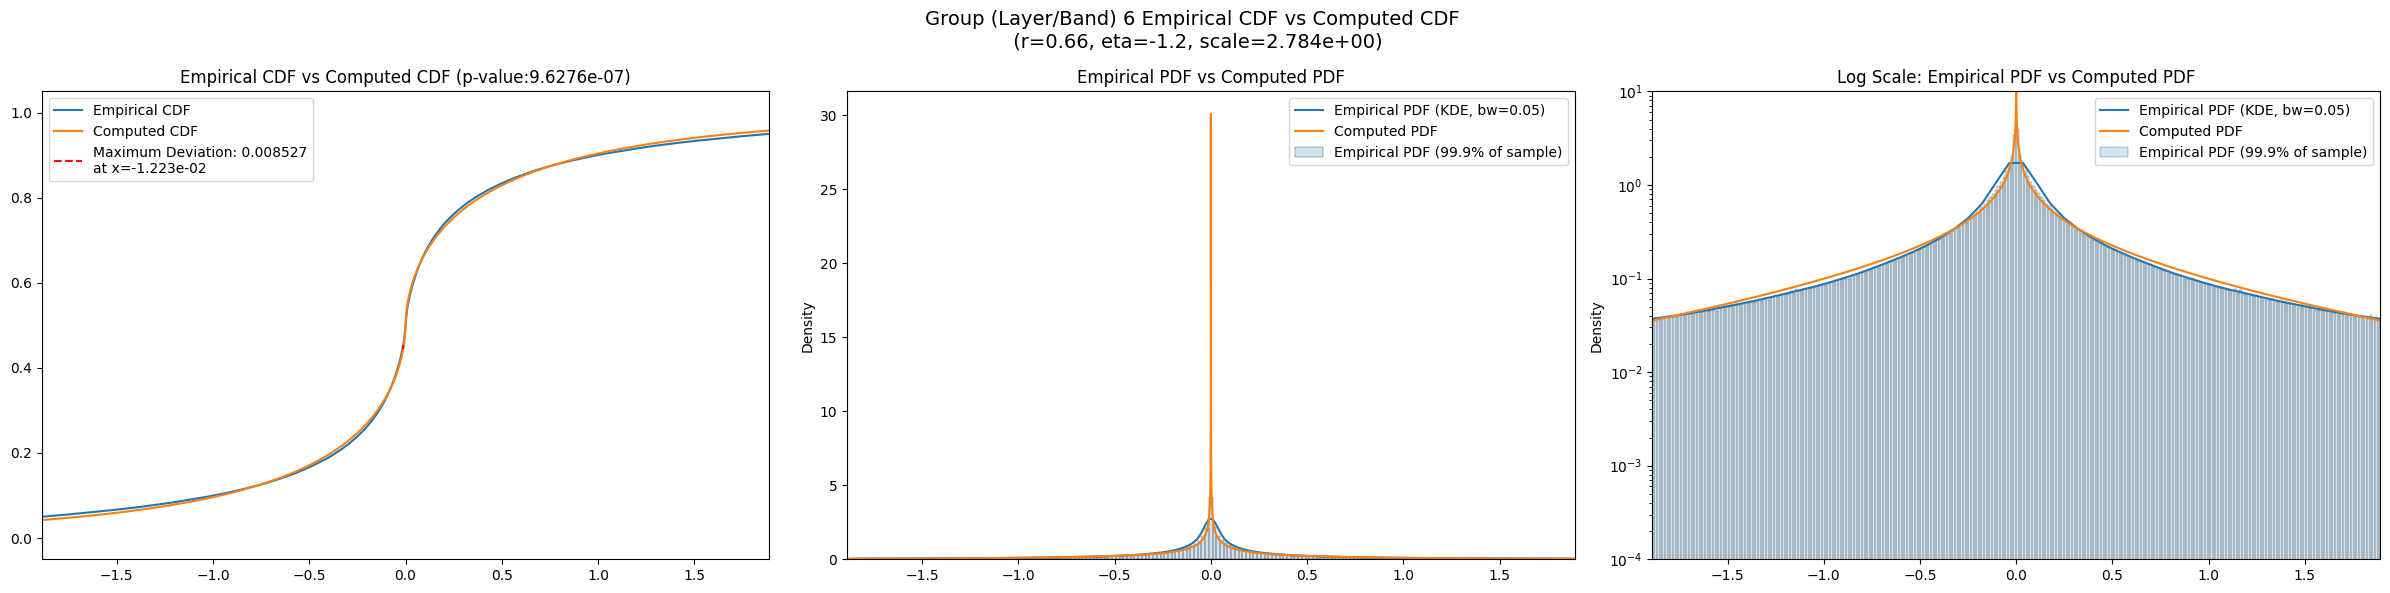

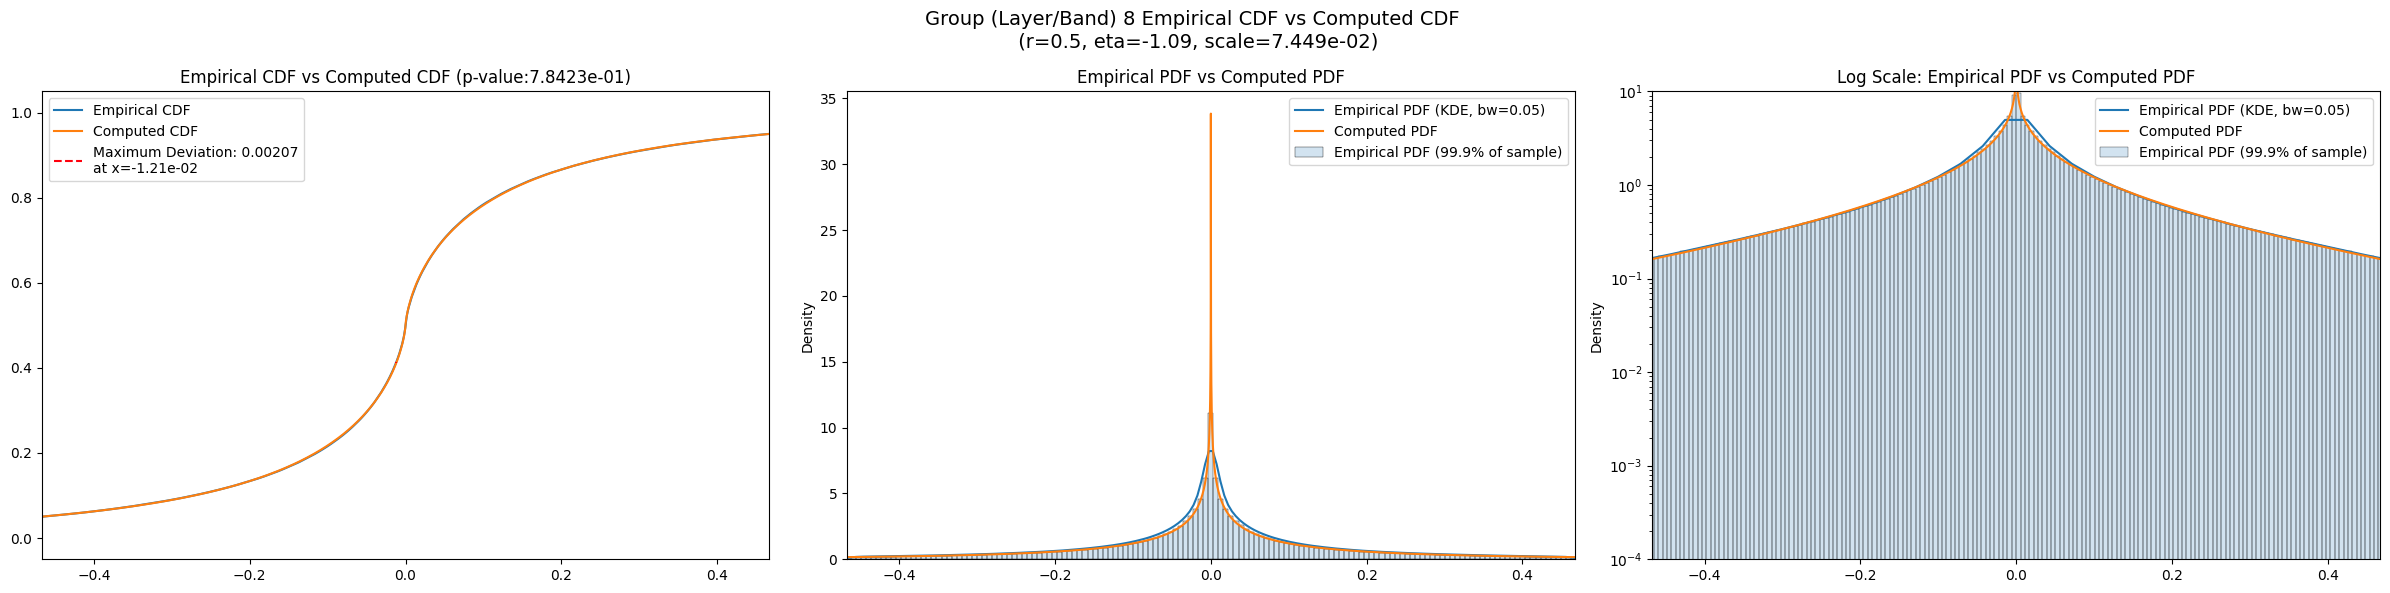

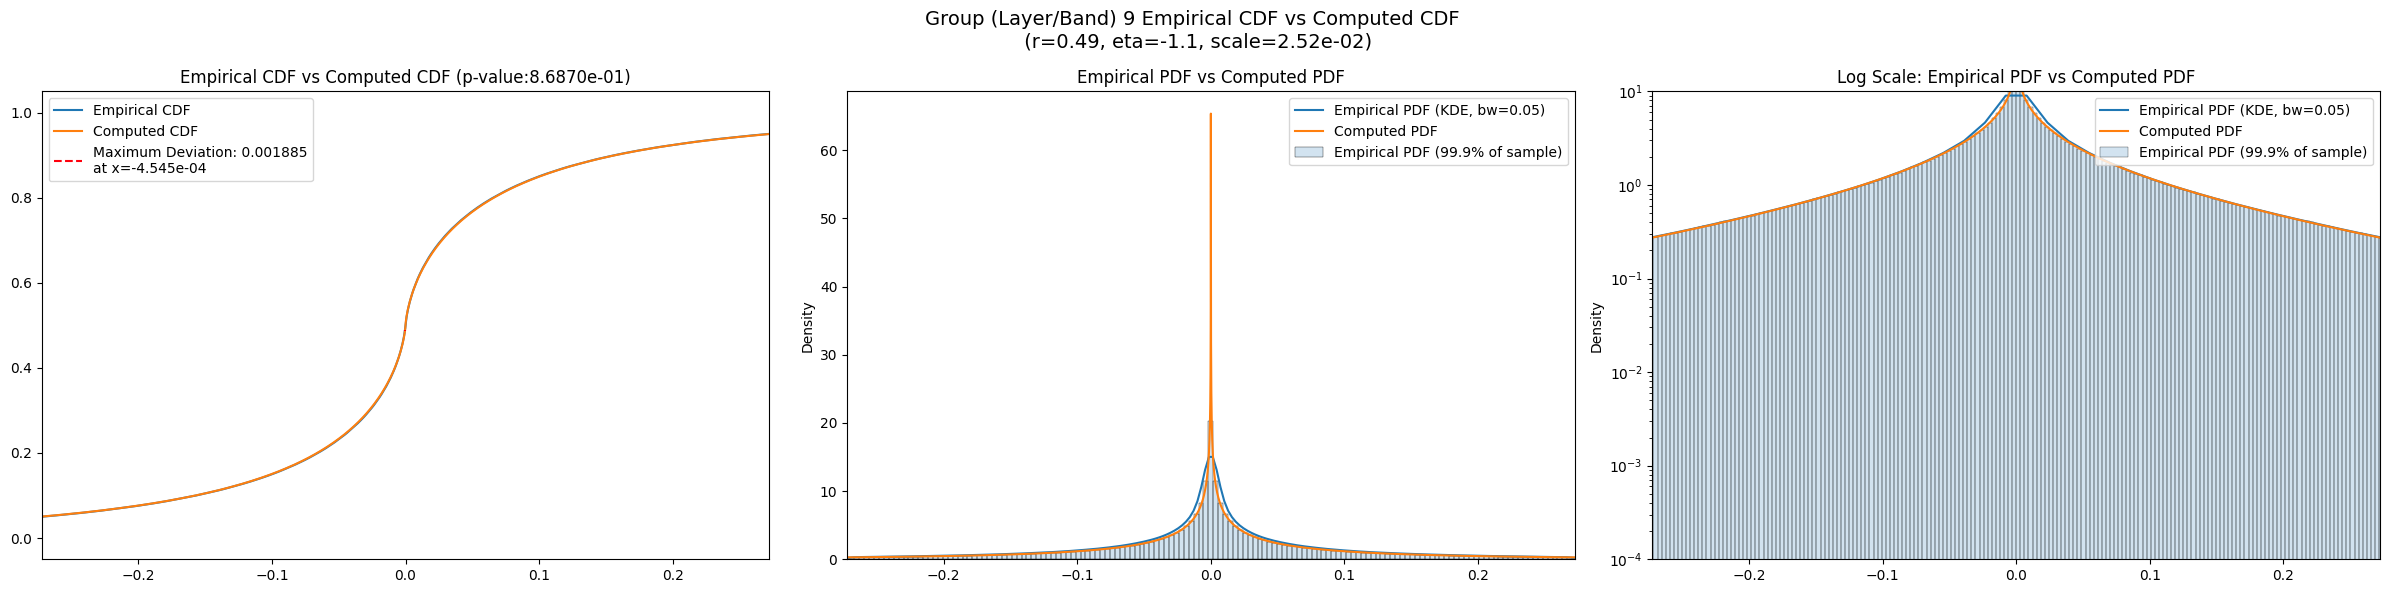

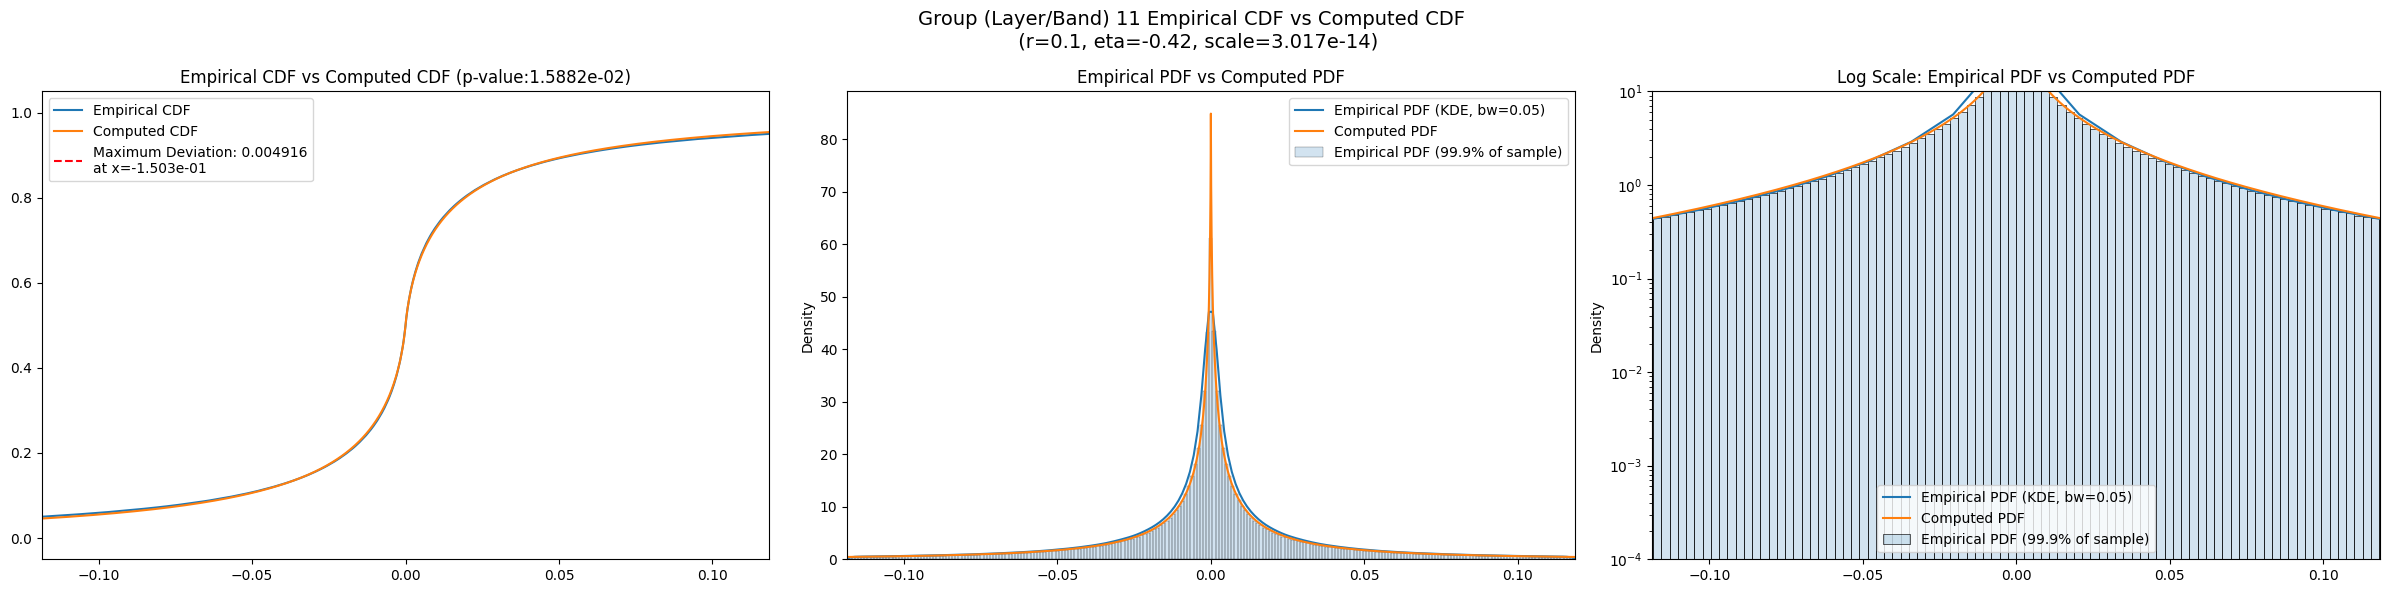

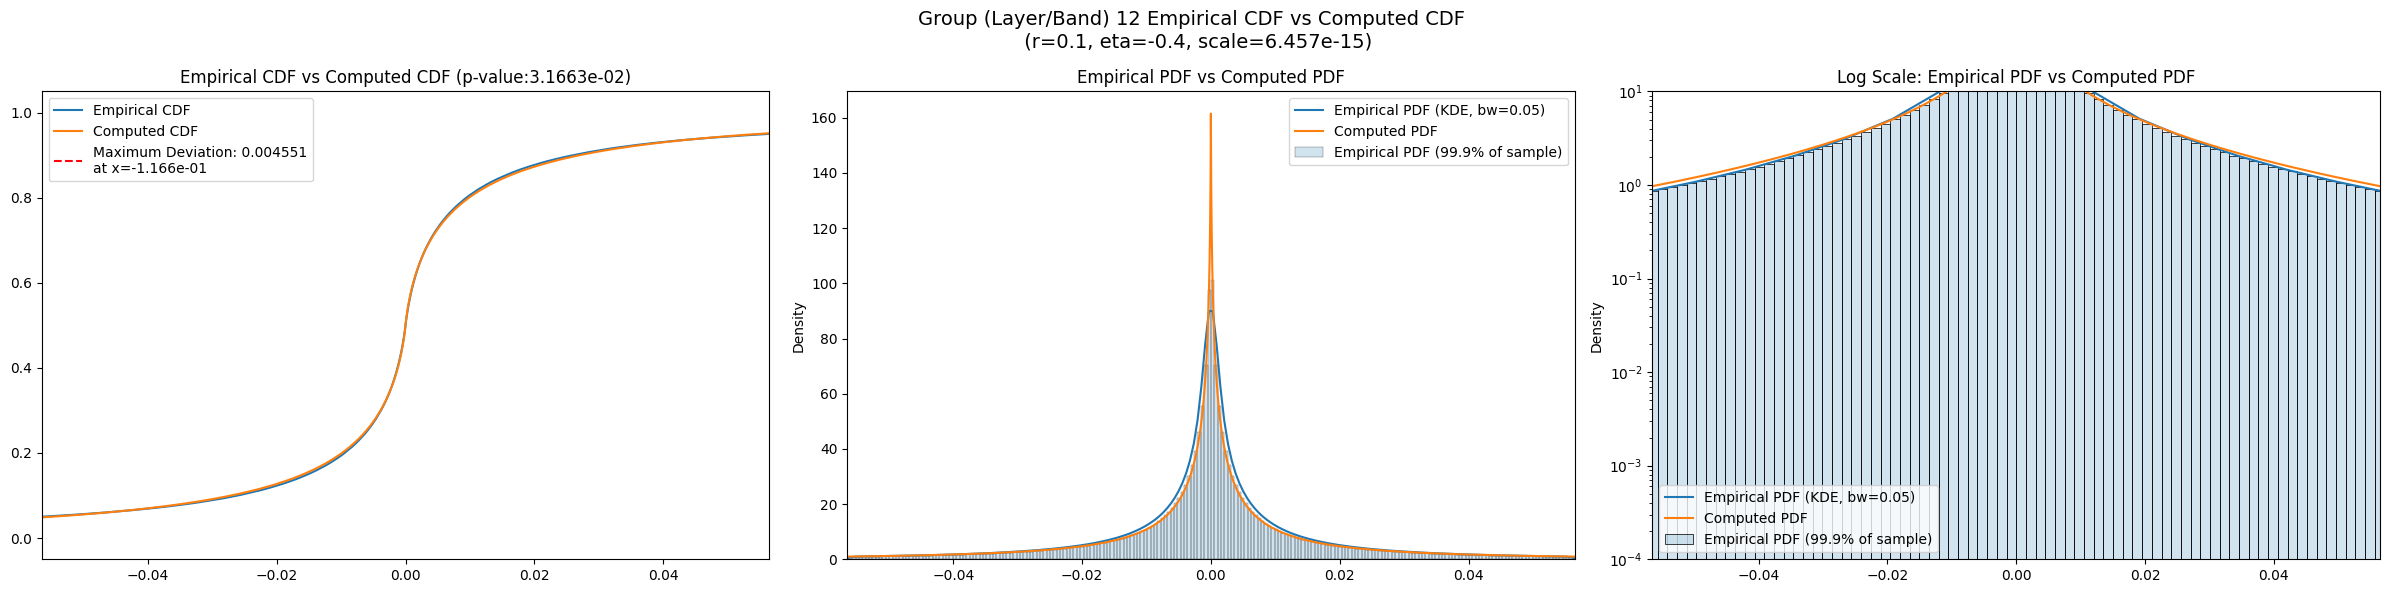

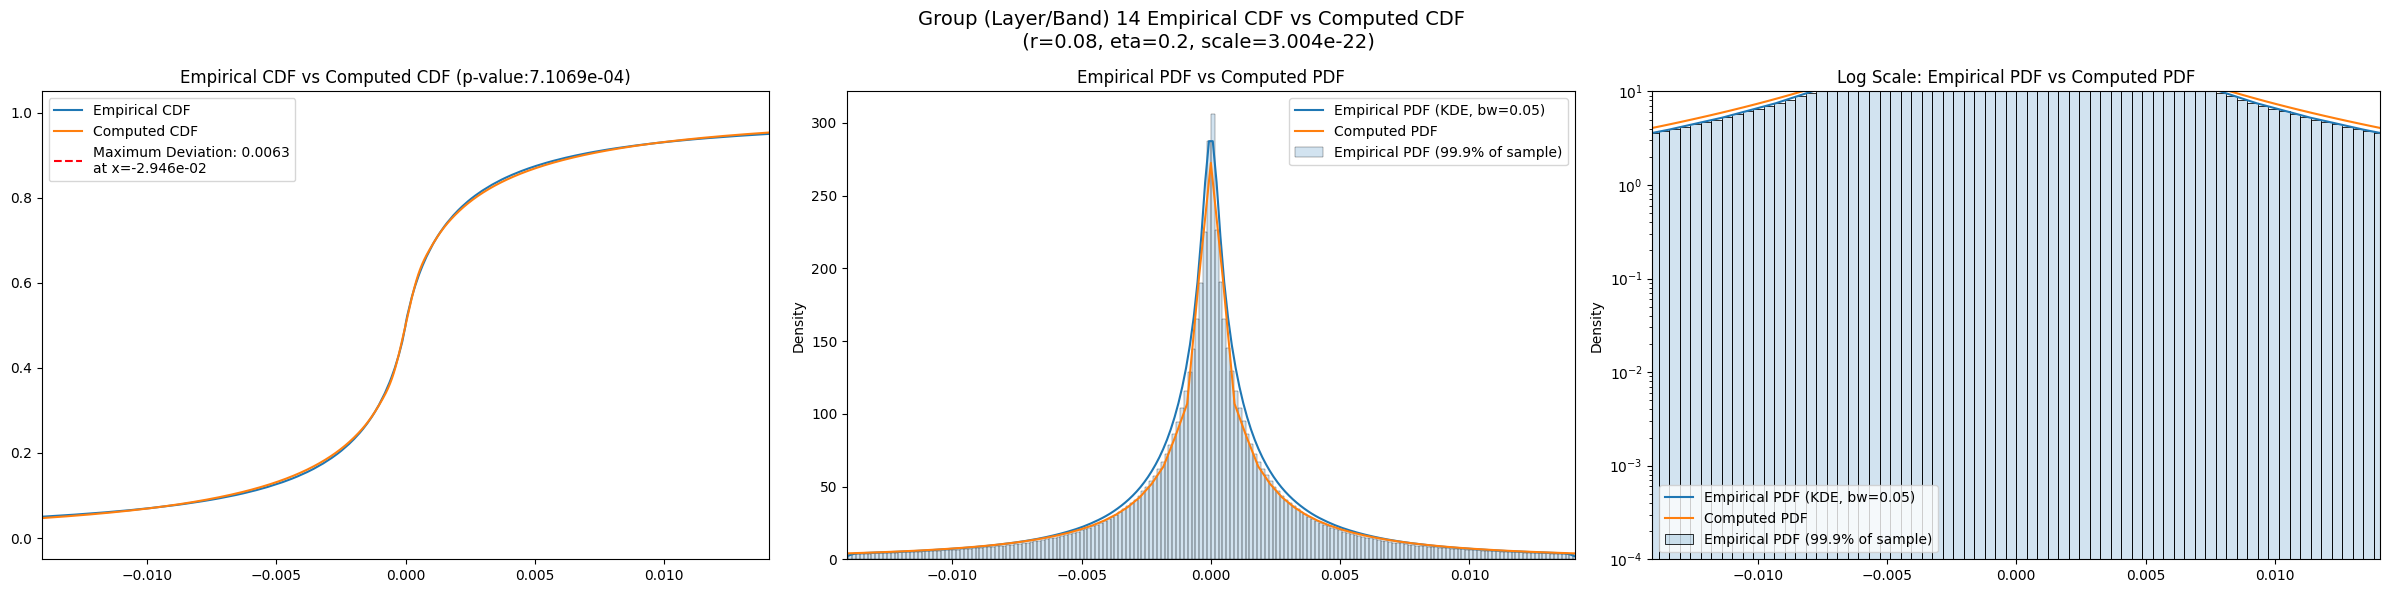

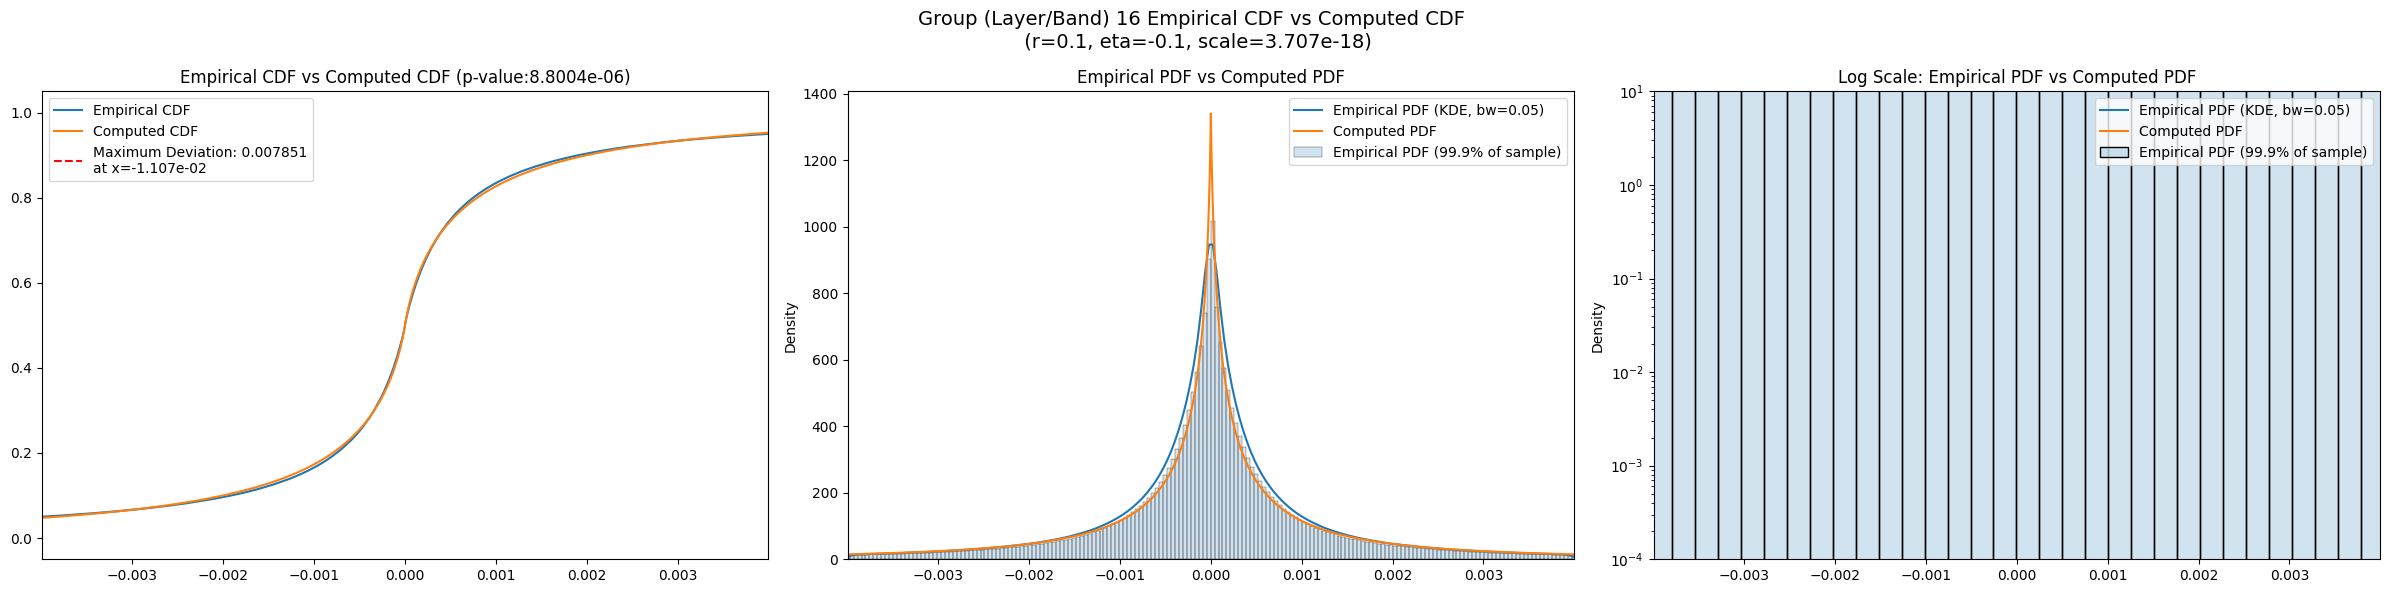

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
band,,,,,,,,,,,,,,,,,,,,,
2,0.028308,0.022991,0.034663,61.312623,37.835383,93.143808,196196.0,0.003010,0.3,-0.6,...,0.067970,0.053847,0.0,0.059334,0.027409,1.781650e-128,0.046825,0.029100,9.132000e-145,1.136015e-01
3,0.465179,0.410659,0.523962,20.291024,17.139798,23.690720,218424.0,0.014987,0.2,-1.0,...,0.142528,0.095574,0.0,0.127703,0.072339,0.000000e+00,0.095430,0.068713,0.000000e+00,9.370657e-36
5,2.054688,1.901839,2.212182,6.662686,5.765408,7.674442,2163728.0,0.007505,0.7,-1.1,...,0.699080,0.073674,0.0,0.598072,0.048300,0.000000e+00,0.470532,0.050741,0.000000e+00,6.538051e-40
6,1.441145,1.327830,1.557888,7.673075,6.762664,8.657274,1092936.0,0.009244,0.7,-1.2,...,0.462849,0.084734,0.0,0.400424,0.060003,0.000000e+00,0.306604,0.059941,0.000000e+00,1.906108e-69
8,0.119060,0.104959,0.135463,22.719707,14.181014,38.698902,7083852.0,0.003284,0.5,-1.1,...,0.143930,0.071826,0.0,0.123651,0.046332,0.000000e+00,0.096759,0.048173,0.000000e+00,8.816516e-27
9,0.038690,0.034166,0.044393,23.432596,12.307179,61.115653,10628850.0,0.002819,0.5,-1.1,...,0.081036,0.074225,0.0,0.069199,0.049330,0.000000e+00,0.054106,0.051361,0.000000e+00,3.116532e-33
11,0.017679,0.014550,0.021377,52.743853,33.994200,94.052447,13469170.0,0.006865,0.1,-0.4,...,0.025022,0.086115,0.0,0.021917,0.061713,0.000000e+00,0.016633,0.060240,0.000000e+00,4.165829e-283
12,0.005020,0.003981,0.006599,93.877350,41.096655,280.321252,44356618.0,0.004552,0.1,-0.4,...,0.012590,0.081585,0.0,0.011080,0.057001,0.000000e+00,0.008416,0.055242,0.000000e+00,0.000000e+00
14,0.000373,0.000267,0.000750,620.008513,46.077857,1725.190022,24973922.0,0.007636,0.1,-0.1,...,0.003552,0.073434,0.0,0.003167,0.048698,0.000000e+00,0.002411,0.045693,0.000000e+00,0.000000e+00


## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_best,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
band,,,,,,
2,0.003010,0.003065,0.002703,0.053847,0.027409,0.029100
3,0.014987,0.002905,0.013645,0.095574,0.072339,0.068713
5,0.007505,0.000923,0.004584,0.073674,0.048300,0.050741
6,0.009244,0.001299,0.008527,0.084734,0.060003,0.059941
8,0.003284,0.000510,0.002070,0.071826,0.046332,0.048173
9,0.002819,0.000417,0.001885,0.074225,0.049330,0.051361
11,0.006865,0.000370,0.004916,0.086115,0.061713,0.060240
12,0.004552,0.000204,0.004552,0.081585,0.057001,0.055242
14,0.007636,0.000272,0.006300,0.073434,0.048698,0.045693


In [21]:
master_df.filter(regex="best.*")

,best_augmented_var,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff
band,,,,,,
2,0.017603,0.002703,0.30,-0.62,1.740868e-04,175.0
3,0.429554,0.013645,0.25,-1.10,6.235392e-03,50.0
5,2.054688,0.004584,0.80,-1.15,4.590333e+00,0.0
6,1.411239,0.008527,0.66,-1.20,2.784247e+00,25.0
8,0.111170,0.002070,0.50,-1.09,7.449108e-02,25.0
9,0.038690,0.001885,0.49,-1.10,2.519787e-02,0.0
11,0.017679,0.004916,0.10,-0.42,3.017086e-14,0.0
12,0.004329,0.004552,0.10,-0.40,6.456972e-15,25.0
14,0.000209,0.006300,0.08,0.20,3.004172e-22,150.0
